# Ch07 RNN을 사용한 문장 생성
- 말뭉치를 이용해 학습한 언어모델을 이용하여 새로운 문장을 만들어 낼것.
- seq2seq( sequence to sequence): 한 시계열 데이터를 다른 시계열 데이터로 변환하는것.

# 7.1 언어모델을 사용한 문장 생성
## 7.1.1 RNN을 사용한 문장 생성의 수서
- " you say goodbye and i say hello" 라는 말뭉치가 있다고 생각. 
- 학습 언어 모델에 "i"라는 단어를 입력으로 주변 확률 분포를 출력한다. 이 분포를 이용하여 단어를 생성하는 방법
1. 확률이 가장 높은 단어를 선택: 결과가 일정하게 정해져 있는 결정적인 방법 > 결과가 예측가능한 것
2. 확률적으로 선택: 이 방식에서는 선택되는 단어가 매번 다를 수 있다.  > 결과가 확률에 따라 정해지기 때문에 실행할때마다 달라진다. 

## 7.1.2 문장 생성 구현

In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm



class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

- PTB 데이터셋은 이미 전처리를 해둔 상태. 희소한 단어는 [unk] 숫자는 N으로 대체. 각문장을 구분하는데 [eos]라는 문자열 사용

In [8]:
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../ch06/Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you booming with the department of abolish residential products.
 the beach coffee is likely not either why traffic would result in mrs. marcos mr. icahn 's hybrid cross-border private and you need are n't softening if the structure had yet as staging raising computers mansion program and funds and magazines between such historical time.
 a series of compliance for workers that japanese ought that the ability when mr. honecker will benefit more difficult to the pentagon deal but a network is troubled by large marketers on the rumors of three weeks but earth includes his prototype because he


# 7.2 seq2seq(2개의 RNN사용)
- Encoder Decoder 모델이라고 한다.
- Encoder: 입력데이터를 인코딩(부호화)하고, Decoder는 인코딩된 데이터를 디코딩(복호화)한다.

In [9]:
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


# 7.3 seq2seq 구현

In [10]:
# Encoder 
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [11]:
# Decoder 
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

## 7.3.3 seq2seq 클래스

In [12]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [15]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 3[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 4[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 6[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 7[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 8[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 10[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 11[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 12[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 15[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 18[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 19[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 21[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 22[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 24[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 25[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 27[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 30[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000


C:\Users\a\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\a\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\a\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\a\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\a\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\a\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text

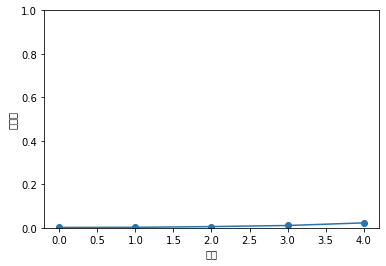

In [19]:
# 평가 
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 5
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

# 7.4 seq2seq 개선
1. 속도 개선

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 3[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 5[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 7[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 8[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 10[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 11[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 13[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 14[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 16[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 18[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 20[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 21[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 23[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 24[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 26[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 27[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1000
---
Q  48+285
T 666 
X 1001
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1001
---
Q 752+006
T 857 
X 1000
---
Q 292+167
T 1053
X 1000
---
Q 795+038
T 1427
X 1000


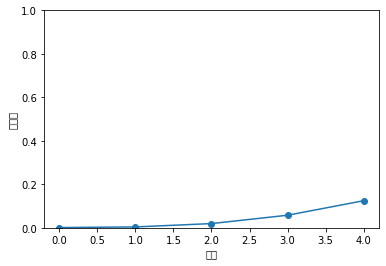

In [21]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()


x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 5
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

# 7.4.2 엿보기 (Peeky)

In [22]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.49
| 에폭 1 |  반복 41 / 351 | 시간 3[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 6[s] | 손실 1.84
| 에폭 1 |  반복 101 / 351 | 시간 8[s] | 손실 1.80
| 에폭 1 |  반복 121 / 351 | 시간 9[s] | 손실 1.79
| 에폭 1 |  반복 141 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 161 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 181 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 16[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 18[s] | 손실 1.75
| 에폭 1 |  반복 241 / 351 | 시간 20[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 21[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 23[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 24[s] | 손실 1.73
| 에폭 1 |  반복 321 / 351 | 시간 26[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 28[s] | 손실 1.73
Q 77+85  
T 162 
X 107 
---
Q 975+164
T 1139
X 1011
---
Q 582+84 
T 666 
X 103 
---
Q 8+155  
T 163 
X 101 
---
Q 367+55 
T 422 
X 103 
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1011
-

| 에폭 8 |  반복 321 / 351 | 시간 21[s] | 손실 0.73
| 에폭 8 |  반복 341 / 351 | 시간 22[s] | 손실 0.71
Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1037
---
Q 830+597
T 1427
X 1437
---
Q 26+838 
T 864 
X 869 
---
Q 143+93 
T 236 
X 231 
---
검증 정확도 12.480%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.70
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.70
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.70
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.70
| 에폭 9 |  반복 81 / 351 | 시간 5[s] | 손실 0.70
| 에폭 9 |  반복 101 / 351 | 시간 6[s] | 손실 0.69
| 에폭 9 |  반복 121 / 351 | 시간 9[s] | 손실 0.69
| 에폭 9 |  반복 141 / 351 | 시간 12[s] | 손실 0.68
| 에폭 9 |  반복 161 / 351 | 시간 15[s] | 손실 0.68
| 에폭 9 |  반복 181 / 351 | 시간 18[s] | 손실 0.67
| 에폭 9 |  반복 201 / 351 | 시간 19[s] | 손실 0.68
| 에폭 9 |  반복 221 / 351 | 시간 21[s] | 손실 0.67
| 에폭 9 |  반복 241 / 351 | 시간 22[s] | 손실 0.67
| 에폭 9 |  반복 261 / 351 | 시간 25[s] | 손실 0.67
| 에폭 9 |  반복 2

| 에폭 16 |  반복 101 / 351 | 시간 6[s] | 손실 0.44
| 에폭 16 |  반복 121 / 351 | 시간 8[s] | 손실 0.43
| 에폭 16 |  반복 141 / 351 | 시간 9[s] | 손실 0.44
| 에폭 16 |  반복 161 / 351 | 시간 10[s] | 손실 0.43
| 에폭 16 |  반복 181 / 351 | 시간 12[s] | 손실 0.43
| 에폭 16 |  반복 201 / 351 | 시간 13[s] | 손실 0.42
| 에폭 16 |  반복 221 / 351 | 시간 15[s] | 손실 0.43
| 에폭 16 |  반복 241 / 351 | 시간 16[s] | 손실 0.44
| 에폭 16 |  반복 261 / 351 | 시간 17[s] | 손실 0.43
| 에폭 16 |  반복 281 / 351 | 시간 18[s] | 손실 0.42
| 에폭 16 |  반복 301 / 351 | 시간 20[s] | 손실 0.43
| 에폭 16 |  반복 321 / 351 | 시간 21[s] | 손실 0.45
| 에폭 16 |  반복 341 / 351 | 시간 22[s] | 손실 0.44
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1048
---
Q 830+597
T 1427
X 1429
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 31.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.41
| 에폭 17 |  반복 21 / 351 | 시간 3[s] | 손실 0.41
| 에폭 17 |  반복 41 / 351 | 시간 5[s] | 손실 

Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1436
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 70.680%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.18
| 에폭 24 |  반복 21 / 351 | 시간 2[s] | 손실 0.18
| 에폭 24 |  반복 41 / 351 | 시간 5[s] | 손실 0.18
| 에폭 24 |  반복 61 / 351 | 시간 6[s] | 손실 0.18
| 에폭 24 |  반복 81 / 351 | 시간 7[s] | 손실 0.17
| 에폭 24 |  반복 101 / 351 | 시간 9[s] | 손실 0.18
| 에폭 24 |  반복 121 / 351 | 시간 10[s] | 손실 0.17
| 에폭 24 |  반복 141 / 351 | 시간 11[s] | 손실 0.17
| 에폭 24 |  반복 161 / 351 | 시간 12[s] | 손실 0.17
| 에폭 24 |  반복 181 / 351 | 시간 14[s] | 손실 0.18
| 에폭 24 |  반복 201 / 351 | 시간 15[s] | 손실 0.18
| 에폭 24 |  반복 221 / 351 | 시간 16[s] | 손실 0.17
| 에폭 24 |  반복 241 / 351 | 시간 18[s] | 손실 0.18
| 에폭 24 |  반복 261 / 351 | 시간 20[s] | 손실 0.18
| 에폭 24 |  반복 281 / 351 | 시간 21[s] | 손실 0.17
| 에폭 24 |  반복 301 / 351 | 시간 22[s] | 손실 0.

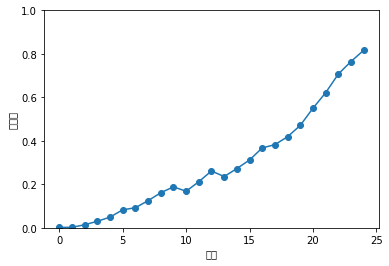

In [24]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()